In [1]:
import Dataset as ds
import config as cfg
from sklearn.model_selection import train_test_split
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [2]:
# Base paths for the images and labels
train_images_path = f'{cfg.BASE_DATASET}/images/train'
train_labels_path = f'{cfg.BASE_DATASET}/labels/train'
val_images_path = f'{cfg.BASE_DATASET}/images/valid'
val_labels_path = f'{cfg.BASE_DATASET}/labels/valid'

# Base path for metadata
metadata_path = f'{cfg.BASE_DATASET}/metadata.json'

# Create the DataFrames for the train and validation sets
train_df = ds.create_dataframe(train_images_path, train_labels_path, metadata_path)
valid_df = ds.create_dataframe(val_images_path, val_labels_path, metadata_path)

In [3]:
dataset_name = 'test500'
dataset_dir = cfg.CLF_DATASET_DIR + f'/{dataset_name}'
class_names = cfg.CLF_CLASS_NAMES


_, test_train_df = train_test_split(
    train_df,
    test_size=500,  # Number of items you want in your sample
    stratify=train_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

_, test_val_df = train_test_split(
    valid_df,
    test_size=100,  # Number of items you want in your sample
    stratify=valid_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

ds.create_sub_dataset(dataset_dir, test_train_df, test_val_df, class_names)


Removing dataset if pre-existing
Copying training files:


Copying files:   0%|          | 0/1000 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset 'test500' created at C:\github\Third-Year-Project\Intruder-Aircraft-Detection\datasets\Custom\test500


# Image Classifier (Not Effective)

In [4]:
ds.correct_dataset_labels(dataset_dir, test_train_df, test_val_df, class_names)

Processing train labels in test500:


Processing labels:   0%|          | 0/500 [00:00<?, ?it/s]

Processing valid labels in test500:


Processing labels:   0%|          | 0/100 [00:00<?, ?it/s]

Label correction completed.


In [5]:

augmentation_metadata = {
    'methods': {        
        'zoom': {
            'parameters': {
                'zoom_factor': 5,  # 50% of full zoom
            },
            'apply_to_percentage': 0.5  # 50% of the training images
        }        
    }
}

ds.augment_dataset(dataset_dir, augmentation_metadata)

Removing existing directories/files:   0%|          | 0/3 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Applying augmentations:   0%|          | 0/250 [00:00<?, ?it/s]

An error occurred: Expected x_max for bbox (0.4856945, 0.37555200000000005, 1.0210155, 0.732432, 1) to be in the range [0.0, 1.0], got 1.0210155.
An error occurred: Expected x_max for bbox (0.13519899999999996, 0.13838100000000003, 1.123123, 0.796997, 2) to be in the range [0.0, 1.0], got 1.123123.
An error occurred: Expected x_min for bbox (-0.05254049999999999, 0.6148480000000001, 0.7579965, 1.1552060000000002, 1) to be in the range [0.0, 1.0], got -0.05254049999999999.


In [6]:
ds.reorganize_dataset_for_keras(dataset_dir)

Moving images in train:   0%|          | 0/500 [00:00<?, ?it/s]

Moving images in train-aug:   0%|          | 0/747 [00:00<?, ?it/s]

Moving images in valid:   0%|          | 0/100 [00:00<?, ?it/s]

# Model

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [8]:
# check GPU available
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

# limit vram usage
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# directories of train, train-aug and validation
train_dir = os.path.join(dataset_dir,'images','train')
train_aug_dir = os.path.join(dataset_dir,'images','train-aug')
valid_dir = os.path.join(dataset_dir,'images','valid')

# load datasets using keras
train_data = tf.keras.utils.image_dataset_from_directory(train_dir)
train_aug_data = tf.keras.utils.image_dataset_from_directory(train_aug_dir)
valid_data = tf.keras.utils.image_dataset_from_directory(valid_dir)

# scale images between 0 and 1
train_data = train_data.map(lambda x,y: (x/255, y))
train_aug_data = train_aug_data.map(lambda x,y: (x/255, y))
valid_data = valid_data.map(lambda x,y: (x/255, y))

Found 500 files belonging to 3 classes.
Found 747 files belonging to 3 classes.
Found 100 files belonging to 3 classes.


In [10]:
# TEST - use numpy to turn dataset into iterator for ease of use with batches, call each batch with .next()
train_iterator = train_data.as_numpy_iterator()
train_batch = train_iterator.next()

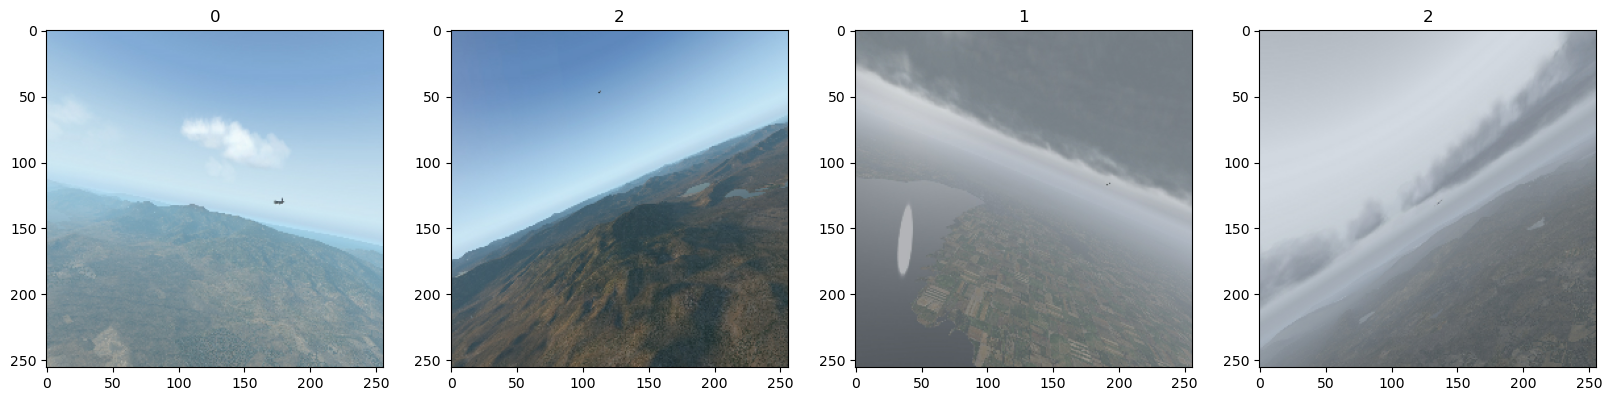

In [11]:
# TEST - visualise images with class labels
train_batch = train_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(train_batch[1][idx])


In [12]:
# use numpy to turn dataset into iterator for ease of use with batches, call each batch with .next()
train_data.as_numpy_iterator().next()
train_aug_data.as_numpy_iterator().next()
valid_data.as_numpy_iterator().next()

print("done")


done


In [13]:
# model architecture - Also try ResNet50 or VGG16
model = Sequential()
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3))) # keras default image size
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy']) # multiclass loss function
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [14]:
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

train_hst = model.fit(train_aug_data, epochs=20, validation_data=valid_data, callbacks=[tensorboard_callback])

Epoch 1/20


: 

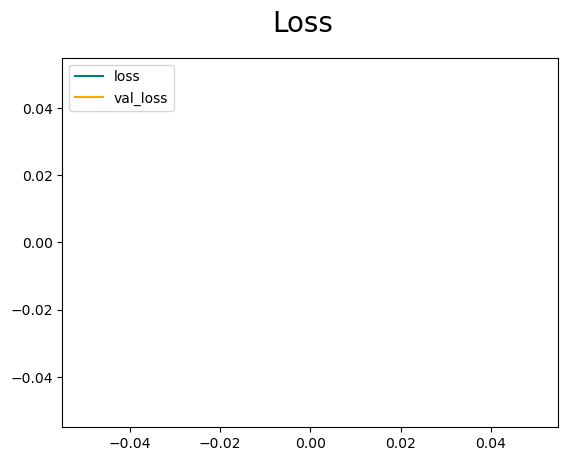

In [13]:
# loss
fig = plt.figure()
plt.plot(train_hst.history['loss'], color='teal', label='loss')
plt.plot(train_hst.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

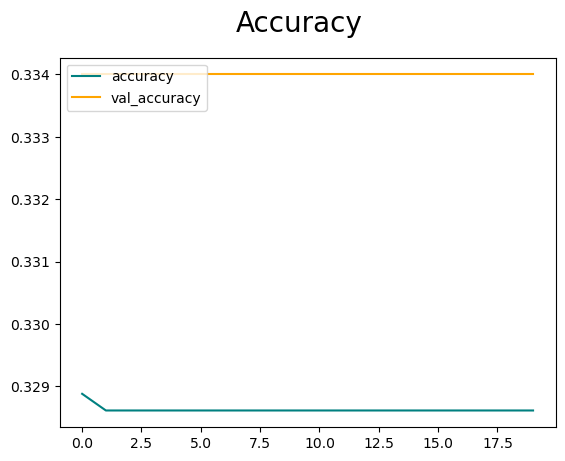

In [14]:
# accuracy
fig = plt.figure()
plt.plot(train_hst.history['accuracy'], color='teal', label='accuracy')
plt.plot(train_hst.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()